All the modules used in creating this notebook is open-source and free.



# Reading and Analyzing data

In [ ]:
#reading the excel file
import pandas as pd
dfs = pd.read_excel('/content/Datasets EY GDS.xlsx')

In [ ]:
input = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Input')

In [ ]:
input.head()

,Exception (input),Queue,Process
0,Invite not found in both CBS mailbox,Queue-12,Process-9
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11
4,Could not execute code stage because exception...,Queue-16,Process-13


In [ ]:
tag = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Keywords for tagging')

In [ ]:
tag.head()

,Keywords for System Exception,Keywords for Business Exception
0,Unable to launch service,Missing the mandatory fields
1,Failed to fetch data,Mail Id not found
2,Failed fetching Site issue,Invite is not found
3,Code stage not executed,Template is not found
4,Exception occured in processing,Error in Input File


# Data Cleaning

Regex helps in cleaning text based data on the basis of pattern. </br>
Using regular rexpressions we have cleaned our data in following ways:
1. Conversions of entire text in lower cases
2. Removing texts between brackets 
3. Removing digits and unwanted symbols
4. Removing extra white spaces

In [ ]:
#importing regex for data cleaning
import re   

def cleaning_data(text): #function that cleans the data
  text=text.lower()   #converting text to lower case
  text=re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)  #removing text between brackets
  text=re.sub(r'[^a-zA-Z ]+', '', text)   #removing all characters except letters
  text=re.sub("\s+"," ",text)   #removing extra white spaces
  return text

In [ ]:
#passing text to get cleaned
text = input["Exception (input)"][0]
text = cleaning_data(text)

In [ ]:
print(text)

invite not found in both cbs mailbox


# Extracting Keyword

We have implemented YAKE! for extraction of keywords from texts.</br>
Reasons to use Yake! over many other keyword extracting techniques are:
1. It is light-weight, unsupervised approach
2. It has outperformed many of the exisiting state-of-the-art methods
3. It is corpus and domain independent

In [ ]:
#installing and importing yake
!pip install yake

import yake

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 
  Created wheel for segtok: filename=segtok-1.5.10-cp37-none-any.whl size=25019 sha256=4014b0135c640d7c5b1bb047c68225bfa203d3ab224bf4d7d3ebc335f1437add
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
Successfully built segtok


In [ ]:
#providing the parameters
language = "en"
max_ngram_size = 4
numOfKeywords = 2

kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, top=numOfKeywords, features=None)

#extracting the keywords
keywords = kw_extractor.extract_keywords(text)

#list of keywords
sentences=[]
sentences.append(text)
for kw in keywords:
  sentences.append(kw[0])

# Classifying Keywords

In [ ]:
#list of system exceptions
Sys_Exception=[]
for i in range(11):
  Sys_Exception.append(tag['Keywords for System Exception'][i])

In [ ]:
#list of business exceptions
Bus_Exception=[]
for i in range(8):
  Bus_Exception.append(tag['Keywords for Business Exception'][i])

In [ ]:
!pip install sent2vec

     |████████████████████████████████| 2.1MB 5.3MB/s 
     |████████████████████████████████| 901kB 24.0MB/s 
     |████████████████████████████████| 3.3MB 43.6MB/s 


In [ ]:
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

In [ ]:
#converting the keywords into vectors
vectorizer1 = Vectorizer()
vectorizer1.bert(sentences)
vectors_bert1 = vectorizer1.vectors

In [ ]:
#converting the system exception into vectors
vectorizer2 = Vectorizer()
vectorizer2.bert(Sys_Exception)
vectors_bert2 = vectorizer2.vectors

In [ ]:
#converting the business exception into vectors
vectorizer3 = Vectorizer()
vectorizer3.bert(Bus_Exception)
vectors_bert3 = vectorizer3.vectors

In [ ]:
#minimum distance from text is printed
min1 = 100
min2 = 100
for k in range(3):
  for i in range(11):
    min1 = min(min1, spatial.distance.cosine(vectors_bert1[k], vectors_bert2[i]))
  for i in range(8):
    min2 = min(min2, spatial.distance.cosine(vectors_bert1[k], vectors_bert3[i]))
if (min1<min2):
  print("System Exception")
else:
  print("Business Exception")

Business Exception


# Extracting similar issues

Implementation of BM25 for similar top-n text retrieval.

In [ ]:
!pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi

#tokenizing the corpus from where to retrieve similar issues
corpus = input["Exception (input)"]

tokenized_corpus = [doc.split(" ") for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
#using the first keyword as query

query = sentences[0]
tokenized_query = query.split(" ")

In [ ]:
scores = bm25.get_scores(tokenized_query)

In [ ]:
#receiving top-3 similar issues from the text
arr=bm25.get_top_n(tokenized_query, corpus, n=3)

In [ ]:
lst=[]
for i in range(3):
  lst.append(input.index[input['Exception (input)'] == arr[i]].tolist())

In [ ]:
lst

[[0], [2], [9]]

# Finding Solution

As we have find the similar documents we just have to see the solutions to those exceptions. If all issues are same we need to return just one.

In [3]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#importing transformers
!pip install transformers

     |████████████████████████████████| 2.1MB 16.0MB/s 
     |████████████████████████████████| 3.3MB 44.7MB/s 
     |████████████████████████████████| 901kB 38.6MB/s 


In [4]:
import torch # the main pytorch library
import torch.nn.functional as f # the sub-library containing different functions for manipulating with tensors

# huggingface's transformers library
from transformers import BertModel, BertTokenizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
bert_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

In [7]:
model = model.eval()

In [8]:
model = model.to(device)

In [9]:
texts  = [
    'Obama speaks to the media in Illinois',
    'The president greets the press in Chicago',
    'Oranges are my favorite fruit',
]

In [10]:
encodings = tokenizer(
    texts, # the texts to be tokenized
    padding=True, # pad the texts to the maximum length (so that all outputs have the same length)
    return_tensors='pt' # return the tensors (not lists)
)

In [11]:
encodings = encodings.to(device)

In [12]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
encodings['input_ids']

tensor([[  101,  8112,  8847,  2000,  1996,  2865,  1999,  4307,   102,     0],
        [  101,  1996,  2343, 17021,  2015,  1996,  2811,  1999,  3190,   102],
        [  101,  4589,  2015,  2024,  2026,  5440,  5909,   102,     0,     0]])

In [14]:
encodings['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [15]:
encodings['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
for tokens in encodings['input_ids']:
    print(tokenizer.convert_ids_to_tokens(tokens))

['[CLS]', 'obama', 'speaks', 'to', 'the', 'media', 'in', 'illinois', '[SEP]', '[PAD]']
['[CLS]', 'the', 'president', 'greet', '##s', 'the', 'press', 'in', 'chicago', '[SEP]']
['[CLS]', 'orange', '##s', 'are', 'my', 'favorite', 'fruit', '[SEP]', '[PAD]', '[PAD]']


In [17]:
with torch.no_grad():
    # get the model embeddings
    embeds = model(**encodings)

In [18]:
embeds = embeds[0]

In [19]:
def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        
        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax
        
        # get the i-th distance
        distance = distances[i]
        
        # create the heatmap
        axes.imshow(distance)
        
        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        
        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        
        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")
        
        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()

In [20]:
CLSs = embeds[:, 0, :]

In [21]:
# normalize the CLS token embeddings
normalized = f.normalize(CLSs, p=2, dim=1)
# calculate the cosine similarity
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()

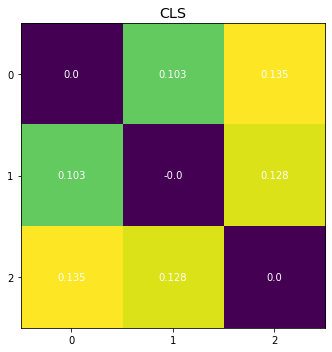

In [22]:
visualize([cls_dist], titles=["CLS"])

In [24]:
MEANS = embeds.mean(dim=1)

In [25]:
# normalize the MEANS token embeddings
normalized = f.normalize(MEANS, p=2, dim=1)
# calculate the cosine similarity
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.numpy()

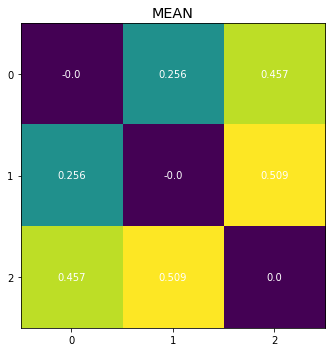

In [26]:
visualize([mean_dist], titles=["MEAN"])

In [27]:
MAXS, _ = embeds.max(dim=1)

In [28]:
# normalize the MEANS token embeddings
normalized = f.normalize(MAXS, p=2, dim=1)
# calculate the cosine similarity
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.numpy()

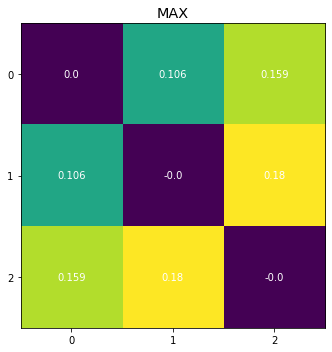

In [29]:
visualize([max_dist], titles=["MAX"])

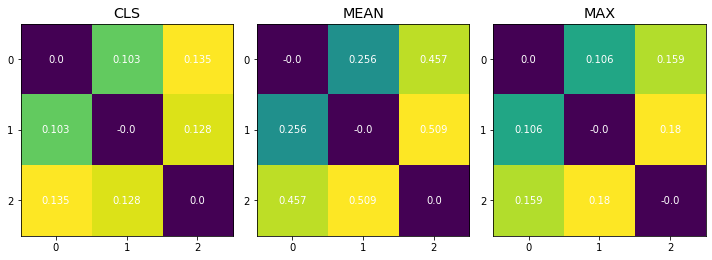

In [30]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)

In [8]:
#reading the datasets
train = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Training Data ')

In [10]:
train.head()

,Exception (input),Queue,Process,Exception Category (ouput),Solution
0,Invite not found in both CBS mailbox,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11,System Exception,Lorem Ipsum is simply dummy text of the printi...
4,Could not execute code stage because exception...,Queue-16,Process-13,System Exception,Lorem Ipsum is simply dummy text of the printi...
